<a href="https://colab.research.google.com/github/AnushkaMazumdar2/Re-inforcement-Learning/blob/main/2348505_Lab6(RL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Necessary Libraries**

In [15]:
import gym
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt

### **1. Setting up the CartPole Environment**

This part of the code initializes the CartPole-v1 environment from the gym library. It then retrieves the dimensions of the state space and the action space, which are used to define the learning agent. The state dimension represents the number of variables describing the environment's state, while the action dimension is the number of discrete actions the agent can take. The print statement outputs these dimensions to confirm the environment setup.

In [16]:
env = gym.make("CartPole-v1")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print(f"State Dimension: {state_dim}, Action Dimension: {action_dim}")

State Dimension: 4, Action Dimension: 2


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### **2. Epsilon-Greedy Action Selection**

This is the implementation of the epsilon-greedy strategy, a popular exploration-exploitation technique in reinforcement learning. The function epsilon_greedy chooses an action based on the epsilon-greedy policy: with probability epsilon, it selects a random action (exploration); otherwise, it selects the action that maximizes the Q-value (exploitation). This method balances exploration and exploitation during the agent's learning process.



In [21]:
def epsilon_greedy(Q, state, epsilon, action_space):
    if np.random.rand() < epsilon:
        return np.random.choice(action_space)
    return np.argmax(Q[state])

### **3. Dyna-Q Agent Class**

The DynaQAgent class defines a reinforcement learning agent that combines model-free and model-based learning using the Dyna-Q algorithm. The agent maintains a Q-table to store the estimated action values for each state and action. The update method updates the Q-values based on real interactions with the environment and performs planning steps where the model (a learned representation of the environment) is used to simulate experiences and update the Q-values. The select_action method chooses an action using the epsilon-greedy policy.

In [22]:
class DynaQAgent:
    def __init__(self, state_dim, action_dim, alpha=0.1, gamma=0.99, epsilon=0.1, planning_steps=5):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.planning_steps = planning_steps
        self.Q = defaultdict(lambda: np.zeros(action_dim))
        self.model = defaultdict(list)
        self.action_space = range(action_dim)

    def update(self, state, action, reward, next_state, done):
        max_next_q = np.max(self.Q[next_state]) if not done else 0
        self.Q[state][action] += self.alpha * (reward + self.gamma * max_next_q - self.Q[state][action])

        self.model[(state, action)] = (reward, next_state, done)

        for _ in range(self.planning_steps):
            s, a = random.choice(list(self.model.keys()))
            r, s_next, d = self.model[(s, a)]
            max_next_q = np.max(self.Q[s_next]) if not d else 0
            self.Q[s][a] += self.alpha * (r + self.gamma * max_next_q - self.Q[s][a])

    def select_action(self, state):
        return epsilon_greedy(self.Q, state, self.epsilon, self.action_space)

### **4. Training the Dyna-Q Agent**

The train_dyna_q function trains the DynaQAgent in the CartPole-v1 environment. For each episode, the agent interacts with the environment, selecting actions based on the epsilon-greedy policy and updating its Q-values using real and simulated experiences. The total reward for each episode is tracked, and the function optionally renders the environment every 100 episodes for visualization. After all episodes are completed, the trained agent is returned along with the rewards collected during training.

In [19]:
def train_dyna_q(env, episodes=500, planning_steps=5, visualize=False):
    agent = DynaQAgent(state_dim, action_dim, planning_steps=planning_steps)
    rewards = []

    for ep in range(episodes):
        state = tuple(env.reset())
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = tuple(next_state)

            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if visualize and ep % 100 == 0:
                env.render()

        rewards.append(total_reward)

    env.close()
    return rewards, agent

### **5. Plotting the Training Rewards**

This snippet runs the training process for 500 episodes with 10 planning steps and then plots the total rewards obtained per episode. The plot helps visualize the learning performance of the Dyna-Q agent, showing how the total rewards change over time and whether the agent is improving its performance.

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


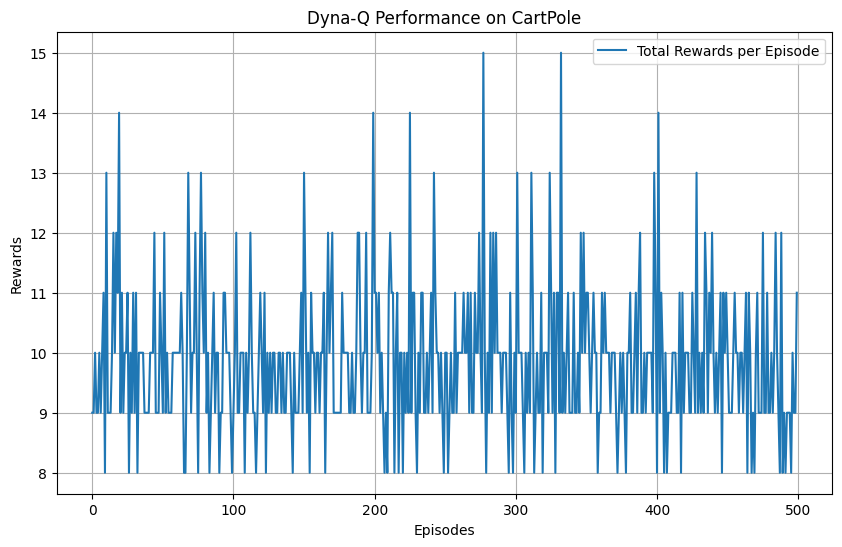

In [20]:
episodes = 500
planning_steps = 10
rewards, trained_agent = train_dyna_q(env, episodes=episodes, planning_steps=planning_steps)

plt.figure(figsize=(10, 6))
plt.plot(rewards, label="Total Rewards per Episode")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Dyna-Q Performance on CartPole")
plt.legend()
plt.grid()
plt.show()

#### **Action Distribution Plot**

This plot can visualize how often the agent chooses each action over time, showing how the exploration-exploitation trade-off (via epsilon-greedy) plays out during training.

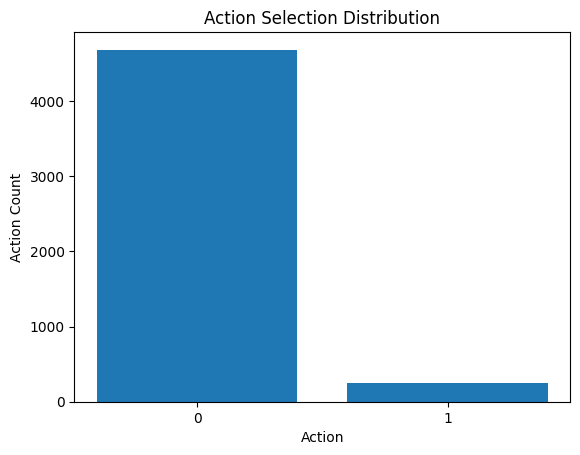

In [25]:
def plot_action_distribution(agent, episodes=500):
    action_counts = np.zeros(len(agent.action_space))

    for ep in range(episodes):
        state = tuple(env.reset())
        done = False
        while not done:
            action = agent.select_action(state)
            action_counts[action] += 1
            next_state, reward, done, _ = env.step(action)
            state = tuple(next_state)

    # Plot the distribution of action selections
    plt.bar(range(len(agent.action_space)), action_counts)
    plt.xlabel('Action')
    plt.ylabel('Action Count')
    plt.title('Action Selection Distribution')
    plt.xticks(range(len(agent.action_space)))
    plt.show()

# Visualize the action selection distribution
plot_action_distribution(trained_agent, episodes=500)

#### **Reward vs. Episode Plot**

This function uses a moving average (convolution) to smooth out the total rewards per episode. It helps to visualize the general learning trend without the noise from fluctuations, making it easier to identify whether the agent's performance is improving over time.

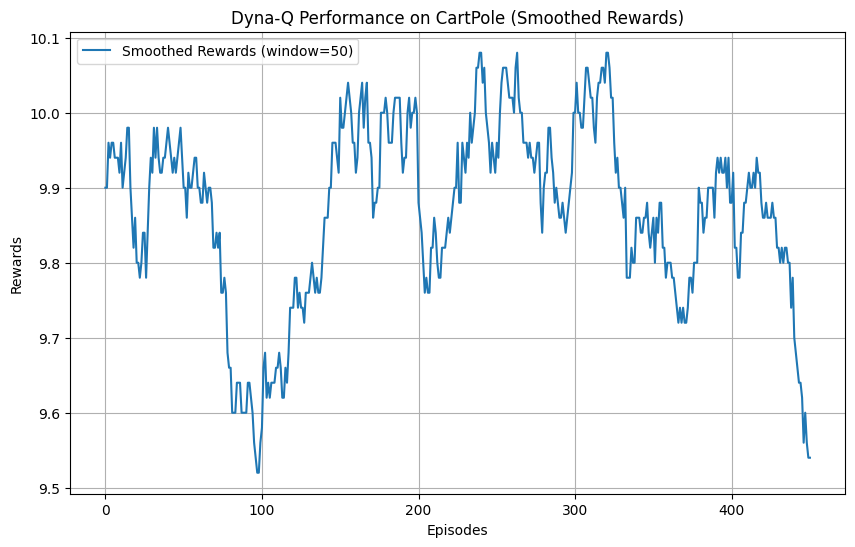

In [26]:
def plot_smoothed_rewards(rewards, window_size=10):
    smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(10, 6))
    plt.plot(smoothed_rewards, label=f"Smoothed Rewards (window={window_size})")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.title("Dyna-Q Performance on CartPole (Smoothed Rewards)")
    plt.legend()
    plt.grid()
    plt.show()

# Visualize smoothed rewards
plot_smoothed_rewards(rewards, window_size=50)




### **Inference:**

The Dyna-Q algorithm is a model-based reinforcement learning approach that uses a learned model of the environment to improve learning efficiency by simulating additional experiences. From the plot generated, you can observe how the total rewards accumulate across episodes. Typically, the rewards should increase over time as the agent refines its policy and the planning steps help the agent learn faster. If the agent performs poorly initially, it suggests that more planning steps or exploration (higher epsilon) might be beneficial.

---